# Argentina´s Hourly Energy Consumption

The aim of this project is to find out if there is a saving in energy consumption by applying either different time zones during the year. This is a common practice in some countries, though there is different views regarding it´s effectiveness.

To do so I will start by adding features to the dataset that explain energy hourly consumption, such as temperature, precipitations, dusk and dawn hours and economic activity level. In the end, the idea is to go from a time series dataset, to a 
dataset compound of different features that explain energy consumption.

Finally, I will train a model to predict future consumption by changing just the clock hour, remaining other features constant. In that way I will evaluate if savings in energy consumption can be achieved by applying different time zones.

Sources: Cammesa, Indec, Meteostat, www.salidaypuestadelsol.com

In [1]:
# Instalation of packages
# pip install category_encoders
# pip install meteostat
# pip install xgboost
# pip install plotly==5.8.0

In [2]:
# Import libraries needed
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from datetime import datetime
from meteostat import Hourly, Stations
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## 1) Time Series Dataset

### A. Data Importation & Wrangling

In [3]:
# Read Excel with energy consumption into a DataFrame and print first 5 rows
df = pd.read_excel('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/Base de datos Horaria-Diaria 2018-2022.xlsx')
df.head()

AÑO        MES  N° MES  N° DIA TIPO DIA                DIA      FECHA  \
0  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   
1  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   
2  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   
3  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   
4  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   

   HORA  Gran Usuario MEM  DISTRIBUIDOR (demanda estacional+GUMEs)  \
0     1          1571.489                                11543.982   
1     2          1569.442                                11178.772   
2     3          1568.841                                10881.543   
3     4          1562.213                                10552.008   
4     5          1558.532                                10288.264   

   DEMANDA LOCAL [MWh]  Exportacion  Bombeo  Perdidas  DEMANDA TOTAL [MWh]  
0            13115.471          0.0     0.0   173.668            13289.139  
1            12748.214          0.0     0.0   496.059            13244.273  
2            12450.384          0.0     0.0   514.231            12964.615  
3            12114.221          0.0     0.0   428.026            12542.247  
4            11846.796          0.0     0.0   321.763            12168.559

I will proceed to understand info and keep what I want for analysis:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37944 entries, 0 to 37943
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   AÑO                                      37944 non-null  int64         
 1   MES                                      37944 non-null  datetime64[ns]
 2   N° MES                                   37944 non-null  int64         
 3   N° DIA                                   37944 non-null  int64         
 4   TIPO DIA                                 37944 non-null  object        
 5   DIA                                      37944 non-null  object        
 6   FECHA                                    37944 non-null  datetime64[ns]
 7   HORA                                     37944 non-null  int64         
 8   Gran Usuario MEM                         37944 non-null  float64       
 9   DISTRIBUIDOR (demanda estacional+GUMEs)

In [5]:
df.describe()

AÑO        N° MES        N° DIA          HORA  \
count  37944.000000  37944.000000  37944.000000  37944.000000   
mean    2019.690070      6.217584     15.714105     12.500000   
std        1.262058      3.496059      8.792642      6.922278   
min     2018.000000      1.000000      1.000000      1.000000   
25%     2019.000000      3.000000      8.000000      6.750000   
50%     2020.000000      6.000000     16.000000     12.500000   
75%     2021.000000      9.000000     23.000000     18.250000   
max     2022.000000     12.000000     31.000000     24.000000   

       Gran Usuario MEM  DISTRIBUIDOR (demanda estacional+GUMEs)  \
count      37944.000000                             37944.000000   
mean        2127.233236                             12837.282505   
std          251.857492                              2514.899029   
min           57.231000                               291.567000   
25%         1976.229250                             10962.396500   
50%         2171.293000                             12596.824500   
75%         2298.279750                             14375.947000   
max         2844.364000                             24010.083000   

       DEMANDA LOCAL [MWh]   Exportacion        Bombeo      Perdidas  \
count         37944.000000  37944.000000  37944.000000  37944.000000   
mean          14964.515741    197.928317     55.334882    496.318437   
std            2581.627657    486.012685    149.522024    149.395838   
min             369.063000      0.000000      0.000000   -264.264000   
25%           13038.432250      0.000000      0.000000    389.957500   
50%           14755.009500      0.000000      0.000000    469.034500   
75%           16562.277750      0.000000      1.055000    577.362000   
max           25908.691000   2938.546000    992.705000   1326.988000   

       DEMANDA TOTAL [MWh]  
count         37944.000000  
mean          15714.097377  
std            2629.706504  
min             105.597000  
25%           13788.418750  
50%           15462.325000  
75%           17381.320250  
max           27049.851000

In [6]:
print(df.select_dtypes('object').nunique())
df['TIPO DIA'].unique()

TIPO DIA    3
DIA         7
dtype: int64


array(['DOMINGO', 'HABIL', 'SABADO'], dtype=object)

Some columns repeat info ("N° MES" and "FECHA") and some columns have information we won´t use ("Exportacion", "Bombeo", "Perdidas"...)

In [7]:
# List columns to drop:
drop_cols = ['MES', 'DIA', 'Gran Usuario MEM', 'DISTRIBUIDOR (demanda estacional+GUMEs)', 'Exportacion', 'Bombeo', 'Perdidas', 'DEMANDA TOTAL [MWh]']

# Drop columns:
df.drop(drop_cols, axis=1, inplace=True)

# Adjust hours to 0-23 instead of 1-24
df['HORA'] = df['HORA'] - 1

# Define "FECHA" as index:
# df.set_index('FECHA', inplace=True)
df.head()

AÑO  N° MES  N° DIA TIPO DIA      FECHA  HORA  DEMANDA LOCAL [MWh]
0  2018       1       1  DOMINGO 2018-01-01     0            13115.471
1  2018       1       1  DOMINGO 2018-01-01     1            12748.214
2  2018       1       1  DOMINGO 2018-01-01     2            12450.384
3  2018       1       1  DOMINGO 2018-01-01     3            12114.221
4  2018       1       1  DOMINGO 2018-01-01     4            11846.796

I wil rename columns to unify language and for better understanding:

AÑO --> Year
N° MES --> Month
N° DIA --> Day
TIPO DIA --> Day Type: If it is weekday, weekend or national holliday.
FECHA --> Date
HORA --> Hour
DEMANDA LOCAL [MWh] --> Consumption [MWh]: Energy Hourly Consumption in MWh

In [8]:
df.rename(columns={'AÑO': 'Year', 'N° MES': 'Month', 'N° DIA': 'Day', 'TIPO DIA': 'Day Type', 'FECHA': 'Date', 'HORA': 'Hour', 'DEMANDA LOCAL [MWh]': 'Consumption [MWh]'}, inplace=True)
df['Day Type'].replace({'DOMINGO': 'Sunday', 'SABADO': 'Saturday', 'HABIL': 'Working day'}, inplace=True)
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]
0  2018      1    1   Sunday 2018-01-01     0          13115.471
1  2018      1    1   Sunday 2018-01-01     1          12748.214
2  2018      1    1   Sunday 2018-01-01     2          12450.384
3  2018      1    1   Sunday 2018-01-01     3          12114.221
4  2018      1    1   Sunday 2018-01-01     4          11846.796

Let´s check if there are missing values:

In [9]:
df.isna().sum()

Year                 0
Month                0
Day                  0
Day Type             0
Date                 0
Hour                 0
Consumption [MWh]    0
dtype: int64

### B. EDA

Now I have the info I need. I will start EDA to find insights in data:

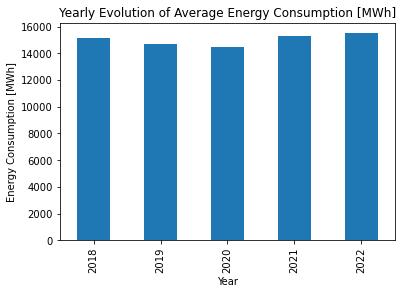

In [10]:
# Group energy consumption by year (info untill 31/3/2022)
df.groupby('Year')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Yearly Evolution of Average Energy Consumption [MWh]');

2020 was the Year with the lowest energy consumption of the series. Lockdown for sure affect industry and economy. Adding a feature as economy activity level will help to explain this variation.

On the other hand, 2022 has the higher consumption but that seems reasonable as it just has summer info, where consumption is higher.

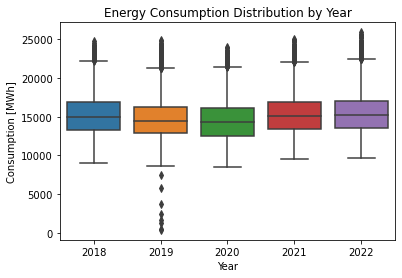

In [11]:
sns.boxplot(x='Year', y='Consumption [MWh]', data=df)
plt.title('Energy Consumption Distribution by Year');

We can see from the boxplots that there are peaks of consumption in every year, but just in 2019 there are outliers of minimum consumption. 

Let´s check for those minimum values:

In [12]:
df[df['Year'] == 2019][['Date','Hour', 'Consumption [MWh]']].sort_values(by='Consumption [MWh]').head(10)

Date  Hour  Consumption [MWh]
12752 2019-06-16     8            369.063
12753 2019-06-16     9            531.163
12754 2019-06-16    10           1281.001
12751 2019-06-16     7           1630.631
12755 2019-06-16    11           2457.595
12756 2019-06-16    12           3707.707
12757 2019-06-16    13           5804.462
12758 2019-06-16    14           7490.366
12759 2019-06-16    15           8664.924
10399 2019-03-10     7           9198.249

9 out of 10 minimal values occur in 2019-06-16! Seems that on that day there was a massive blackout in Argentina, from 7 am to 3 pm:

https://www.infobae.com/sociedad/2019/06/16/masivo-apagon-a-nivel-pais-capital-federal-buenos-aires-y-varias-provincia-estan-sin-luz/

I will proceed to replace those values as we can see that are related to an external and explainable rare event with the average of previous and posterior Sunday:

In [13]:
# Set values to NaN:
df.loc[12751:12759, 'Consumption [MWh]'] = np.nan
# Slice previous and posterior Sunday, concatenate and calculate mean by hour: 
prev = df[(df['Date'] == '2019-06-09') & (df['Hour'] > 6) & (df['Hour'] < 16)]
post = df[(df['Date'] == '2019-06-23') & (df['Hour'] > 6) & (df['Hour'] < 16)]
prev_post = pd.concat([prev, post])
prev_post = prev_post[['Hour', 'Consumption [MWh]']].groupby('Hour').mean()
values = prev_post['Consumption [MWh]']
# Replace NaN values with average values:
df.loc[df['Consumption [MWh]'].isnull(),'Consumption [MWh]'] = df['Hour'].map(values)
df.loc[12751:12759]

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]
12751  2019      6   16   Sunday 2019-06-16     7         11430.7500
12752  2019      6   16   Sunday 2019-06-16     8         11191.3760
12753  2019      6   16   Sunday 2019-06-16     9         11639.0935
12754  2019      6   16   Sunday 2019-06-16    10         12131.0510
12755  2019      6   16   Sunday 2019-06-16    11         12375.1755
12756  2019      6   16   Sunday 2019-06-16    12         12405.2630
12757  2019      6   16   Sunday 2019-06-16    13         12208.4955
12758  2019      6   16   Sunday 2019-06-16    14         11896.8315
12759  2019      6   16   Sunday 2019-06-16    15         11847.8055

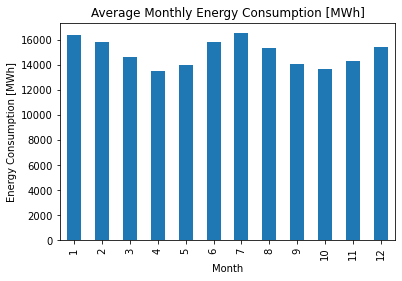

In [14]:
df.groupby('Month')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Monthly Energy Consumption [MWh]');

Consumption has it peaks in Summer's and Winter's months. High temperatures in Summer may affect consumption, as well as Winter's shorter days. I will create a new feature "Season" to go deeper in this analysis. 

In [15]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'autumn': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'winter': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'spring': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['winter']:
        return 'winter'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'summer'

# Assuming df has a date column of type `datetime`
df['season'] = df['Date'].map(season_of_date)

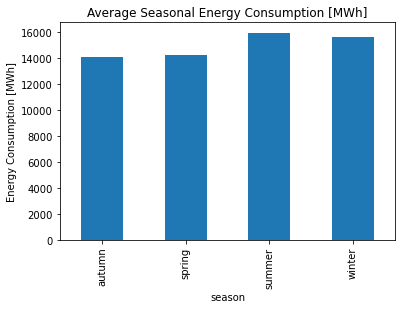

In [16]:
df.groupby('season')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('season')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Seasonal Energy Consumption [MWh]');

Summer is the season with higher energy consumption (and higher temperatures!), followed by Winter (lower temperatures!). 

Now I will plot average hourly consumption:

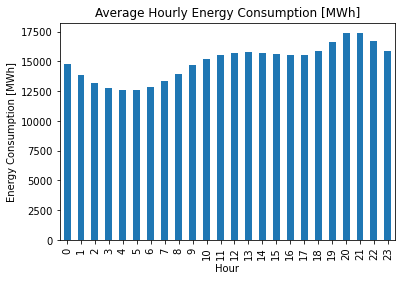

In [17]:
df.groupby('Hour')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Hourly Energy Consumption [MWh]');

I will combine season with hourly consumption to see how consumption is affected by hour, temperature and daylight during the different seasons of the year:

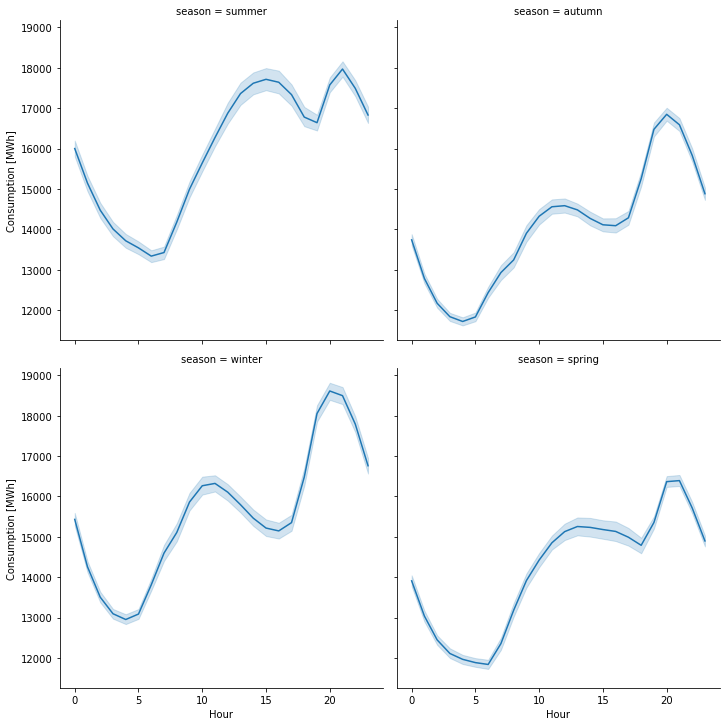

In [18]:
sns.relplot(x="Hour", y="Consumption [MWh]", data=df, kind="line", col="season", col_wrap=2)
plt.show()

Though curves are similar, there are some differences. To highlight them let's plot winter and summer curves together to understand better how energy consumption differs on those seasons:

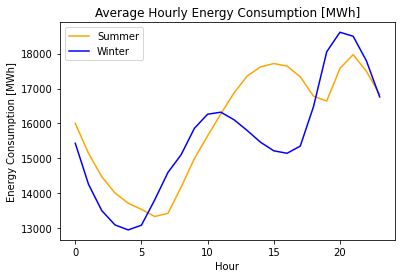

In [19]:
df[df['season'] == 'summer'].groupby('Hour')['Consumption [MWh]'].mean().plot(kind='line', label='Summer', color='orange')
df[df['season'] == 'winter'].groupby('Hour')['Consumption [MWh]'].mean().plot(kind='line', label='Winter', color='blue')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Hourly Energy Consumption [MWh]')
plt.legend();

The beginning and end of both curves look alike but a couple of hours "earlier" for winter. Daylight may be impacting in energy consumption. 
On the other hand, we can see that daily peaks happened in hottest hours for summer and coldest for winter.

Adding features as temperature and daylight hours will definitely help us understand this kind of variations.

Now, I will check if there is variation between working days and weekends:

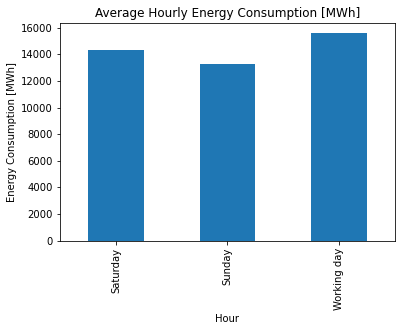

In [20]:
df.groupby('Day Type')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Hourly Energy Consumption [MWh]');

### C. Time Series Modeling

To end this first part of the project, I will develop a Time Series model to predict energy consumption with current information. This model will be the baseline to compare models in the second part of the project . I will choose an AutoRegressive model for timeseries forecasting.

In [21]:
# Create a column with datetime combining Date and Hour and setting it as index:
df['datetime'] = pd.to_datetime(df['Date']) + df['Hour'].astype('timedelta64[h]')
y = df[['datetime', 'Consumption [MWh]']]
y.set_index('datetime', inplace=True)
# Timeseries data in a pandas Series with Datetime as index and Consumption as target feature:
y = y.squeeze()
y.index.freq = 'h'
y.head()

datetime
2018-01-01 00:00:00    13115.471
2018-01-01 01:00:00    12748.214
2018-01-01 02:00:00    12450.384
2018-01-01 03:00:00    12114.221
2018-01-01 04:00:00    11846.796
Freq: H, Name: Consumption [MWh], dtype: float64

Moldel 0 will be the simplest model, predicting consumption base on the mean of the past information.

In [22]:
# Split data into train and test 
cutoff_test = int(0.75 * len(y))
y_train = y[:cutoff_test]
y_test = y[cutoff_test:]
# Calculate a baseline error using the average energy consumption:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_test)
baseline_rmse = (mean_squared_error(y_test, y_pred_baseline) ** 0.5).round(2)
print("Mean Energy Consumption:", y_train_mean)
print("Baseline RMSE:", baseline_rmse)
# Store in a Dictionary each model´s performance:
model_performance = {'0 - Mean': baseline_rmse}
print(model_performance)

Mean Energy Consumption: 14840.60820245635
Baseline RMSE: 2681.08
{'0 - Mean': 2681.08}


To start with Autoregressive model I will plot de Partial Autorrelation function plot. This plot let us see partial correlation between a value with its own lagged values. It is important to determine the appropriate lags (p) in an AR model.

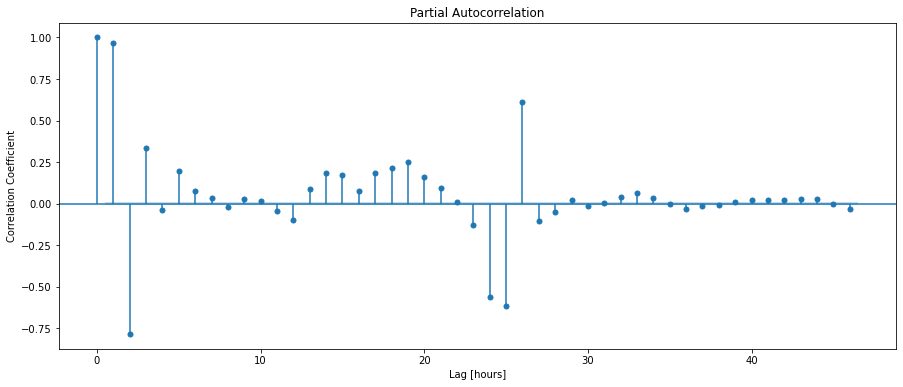

In [23]:
# Plotting pacf:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

I will define p = 26 and use that parameter in AR Model which it will be define in the next step:

In [24]:
# Lags p = 26. Fitting model with y_train:
p = 26
ar = AutoReg(y_train, lags=p, old_names=True).fit()
# Calculating Training RMSE:
y_pred = ar.predict().dropna()
training_rmse = (mean_squared_error(y_train[p:], y_pred) ** 0.5).round(2)
print("AR Training RMSE:", training_rmse)
# Calculating model performance in test data:
y_pred_test = ar.predict(y_test.index[0], y_test.index[-1])
test_rmse = (mean_squared_error(y_test, y_pred_test) ** 0.5).round(2)
print("AR Test RMSE:", test_rmse)
# Appending results to performance dictionary:
model_performance['1 - AR']= test_rmse
print(model_performance)

AR Training RMSE: 168.07
AR Test RMSE: 2660.49
{'0 - Mean': 2681.08, '1 - AR': 2660.49}


AR Model´s performance wasn't better than the simple mean. Let´s plot predictions vs test data to understand model´s performance:

In [25]:
# Create dataframe with two columns, test data and predictions:
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index)
# Plot
fig = px.line(df_pred_test, labels={"value": "Consumption"})
fig.show()

It´s visible that the predictions over time become less and less accurate, similar to just predicting the mean. To solve this I will use walk forward validation, re-training the model with actual data as it gets available for further predictions.

In [26]:
# Build walk foward validation model:
y_pred_wfv = pd.Series(dtype='float64')
history = y_train.copy()
for i in range(len(y_test)):
    ar_wfv = AutoReg(history, lags=p, old_names=True).fit()
    next_pred = ar_wfv.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
# Calculate RMSE:
test_wfv_rmse = (mean_squared_error(y_test, y_pred_wfv) ** 0.5).round(2)
print("Test RMSE (walk forward validation):", test_wfv_rmse)
# Add RMSE to the performance dictionary:
model_performance['2 - AR_wfv'] = test_wfv_rmse
print(model_performance)

Test RMSE (walk forward validation): 171.53
{'0 - Mean': 2681.08, '1 - AR': 2660.49, '2 - AR_wfv': 171.53}


Really great performance! Let´s check it out in a plot:

In [27]:
# Create dataframe with two columns, test data and predictions:
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred": y_pred_wfv}, index=y_test.index)
# Plot
fig = px.line(df_pred_test, labels={"value": "Consumption"})
fig.show()

First part of the project is finished. After importing data I perform EDA and develop 3 models for time series forecasting. New models will be develop in the second part of the project and performance will be compared.

## 2) New Features Dataset 

The goal of this part of the project is to reconvert time series dataset into a dataset dependent on new features such as temperature, precipitations, sunrise and sunset hours and an indicator of economics/industrial activity level. 

I believe this new features will help me partially explain variations of consumption among the different years, seasons, days and hours. The only time related feature I intend to keep is clock´s hour, as this is what is going to be changed to find out if savings in energy consumption can be made by applying different time zones.

### A. Adding new features:

**First Step:**

As Argentina is a vast country this features will differ from North to South and from East to West. Problem is that Consumption target variable is aggregated for the whole country. In a different dataset I found monthly consumption divided by provinces. I will use this information to find the country´s weighted average center.

Having this center then I´ll be able to search for new features based on that location.

In [28]:
# Reading file into a DataFrame and printing first 5 rows:
df_month_prov = pd.read_excel('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/BASE_DEMANDA_INFORME_MENSUAL_2018-2022.xlsx')
df_month_prov.head()

AÑO        MES AGENTE NEMO            AGENTE DESCRIPCION TIPO AGENTE  \
0  2018 2018-01-01    AARGTAOY   AEROP ARG 2000 - Aeroparque          GU   
1  2018 2018-01-01    ABRILHCY           ABRIL CLUB DE CAMPO          GU   
2  2018 2018-01-01    ACARQQ3Y      ASOC.COOP.ARG. - Quequén          GU   
3  2018 2018-01-01    ACARSLSY  ASOC.COOP.ARG. - San Lorenzo          GU   
4  2018 2018-01-01    ACERBR1Y                Planta Bragado          GU   

         REGION     PROVINCIA    CATEGORIA AREA CATEGORIA DEMANDA  \
0   GRAN BS.AS.  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   
1   GRAN BS.AS.  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   
2  BUENOS AIRES  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   
3       LITORAL      SANTA FE  Gran Usuario MEM      Gran Usuario   
4  BUENOS AIRES  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   

                  TARIFA             CATEGORIA TARIFA  DEMANDA [MWh]  
0  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande       2038.283  
1  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande       1581.397  
2  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande        343.544  
3  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande        584.431  
4  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande      22043.186

PROVINCIA
BUENOS AIRES      0.492618
SANTA FE          0.094085
CORDOBA           0.074703
MENDOZA           0.044616
CHUBUT            0.033570
ENTRE RIOS        0.028096
TUCUMAN           0.023673
CHACO             0.022808
CORRIENTES        0.022043
MISIONES          0.019313
SAN JUAN          0.016975
NEUQUEN           0.015980
SALTA             0.015925
RIO NEGRO         0.015026
SGO.DEL ESTERO    0.012677
SAN LUIS          0.012334
LA RIOJA          0.011119
FORMOSA           0.010634
CATAMARCA         0.010237
SANTA CRUZ        0.008836
JUJUY             0.008042
LA PAMPA          0.006690
Name: Weight, dtype: float64

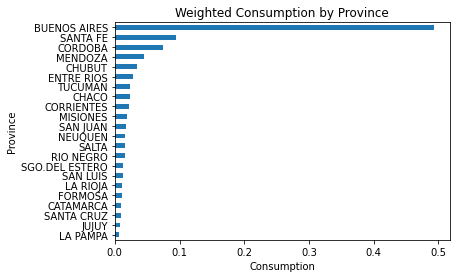

In [29]:
# Grouping Consumption by Province, calculating weight and plotting:
df_prov = df_month_prov.groupby('PROVINCIA')[['PROVINCIA','DEMANDA [MWh]']].sum()
df_prov['Weight'] = df_prov['DEMANDA [MWh]'] / df_prov['DEMANDA [MWh]'].sum()
df_prov['Weight'].sort_values().plot(kind='barh')
plt.xlabel('Consumption')
plt.ylabel('Province')
plt.title('Weighted Consumption by Province');
df_prov['Weight'].sort_values(ascending=False)

Buenos Aires represents almost half of the Country´s Energy Consumption. I will add to this dataframe coordinates of the biggest city of each province to find the weighted average center of the country´s energy consumption:  

In [30]:
# Reading Province´s Coordinates into a dataframe:
df_coord = pd.read_excel('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/Provinces Coordinates.xlsx')
df_coord.head()

PROVINCIA   Latitud  Longitud
0  BUENOS AIRES -34.61315 -58.37723
1     CATAMARCA -28.46957 -65.78524
2         CHACO -27.46056 -58.98389
3        CHUBUT -43.30016 -65.10228
4       CORDOBA -31.41350 -64.18105

In [31]:
# Merging both dataframes:
df_prov = df_prov.merge(df_coord, on='PROVINCIA')
print(df_prov.head())

      PROVINCIA  DEMANDA [MWh]    Weight   Latitud  Longitud
0  BUENOS AIRES   2.747156e+08  0.492618 -34.61315 -58.37723
1     CATAMARCA   5.708801e+06  0.010237 -28.46957 -65.78524
2         CHACO   1.271900e+07  0.022808 -27.46056 -58.98389
3        CHUBUT   1.872105e+07  0.033570 -43.30016 -65.10228
4       CORDOBA   4.165941e+07  0.074703 -31.41350 -64.18105


In [32]:
# Plotting in a map each province's energy consumption to visually understand distribution:
fig = px.scatter_mapbox(
    df_prov,  
    lat='Latitud',
    lon='Longitud',
    width=600,  # Width of map
    height=600,  # Height of map
    size='Weight',
    zoom=3,
    center={'lat': -40,'lon': -65},
    hover_data=['Weight'],  # Display Consumption's weight when hovering mouse over province
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [33]:
# Weighted Latitud and Longitud calculation:
lat = (df_prov['Weight'] * df_prov['Latitud']).sum()
lon = (df_prov['Weight'] * df_prov['Longitud']).sum()
print('lat: ',lat)
print('lon: ', lon)

lat:  -33.4270719126139
lon:  -60.954207296053504


Searching those coordinates in Google Maps we can see that average weighted coordinates are just 50 km away of Rosario, Santa Fe province:

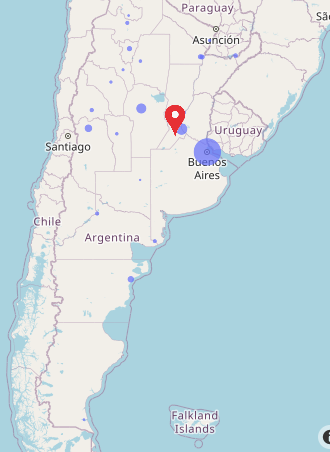

I will calculate each province's distance to the calculated country center:

In [34]:
# Distance from weighted center to each province calculation, and sorting to find out the minimum distance:
df_prov['distance'] = ((df_prov['Latitud'] - lat)**2 + (df_prov['Longitud'] - lon)**2)**0.5
df_prov[['PROVINCIA','distance']].sort_values(by='distance').head()

PROVINCIA  distance
19      SANTA FE  0.574279
6     ENTRE RIOS  1.748891
0   BUENOS AIRES  2.836828
4        CORDOBA  3.803549
9       LA PAMPA  4.610487

Excellent! Then it's defined Rosario, Santa Fe as the average weighted center of the country´s energy consumption.

**Second Step:**

Now it's time to import information about sunrise and sunset and merge that info with the dataframe of hourly consumption. New features will be the amount of sun hours a day has, and a boolean feature expressing if in an specific hour there is sunlight or not.

In [35]:
# Read Sun information from csv into dataframe and print first 5 rows and datatypes:
df_sun_hours = pd.read_csv('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/rosario_sun_data.csv', sep=';')
print(df_sun_hours.head())
print(' ')
print(df_sun_hours.dtypes)

          Dia   Salida    Puesta Horas de sol
0  01/01/2018  5:58:55  20:15:38     14:16:43
1  02/01/2018  5:59:39  20:15:49     14:16:10
2  03/01/2018  6:00:24  20:15:58     14:15:34
3  04/01/2018  6:01:11  20:16:05     14:14:54
4  05/01/2018  6:01:58  20:16:10     14:14:12
 
Dia             object
Salida          object
Puesta          object
Horas de sol    object
dtype: object


In [36]:
# Converting feature to the correct dtype:
df_sun_hours['Date'] = pd.to_datetime(df_sun_hours['Dia'], format='%d/%m/%Y')
df_sun_hours['Sunrise'] = pd.to_datetime(df_sun_hours['Salida'], format='%H:%M:%S')
df_sun_hours['Sunset'] = pd.to_datetime(df_sun_hours['Puesta'], format='%H:%M:%S')
df_sun_hours['Sun Hours'] = pd.to_datetime(df_sun_hours['Horas de sol'], format='%H:%M:%S')
df_sun_hours['Sun Hours'] = df_sun_hours['Sun Hours'].dt.hour + df_sun_hours['Sun Hours'].dt.minute / 60 + df_sun_hours['Sun Hours'].dt.second / 3600
df_sun_hours.drop(columns=['Dia', 'Salida', 'Puesta', 'Horas de sol'], inplace=True)
df_sun_hours.dtypes

Date         datetime64[ns]
Sunrise      datetime64[ns]
Sunset       datetime64[ns]
Sun Hours           float64
dtype: object

In [37]:
# Merging original dataset with sun information:
df = df.merge(df_sun_hours, on='Date')
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]  season  \
0  2018      1    1   Sunday 2018-01-01     0          13115.471  summer   
1  2018      1    1   Sunday 2018-01-01     1          12748.214  summer   
2  2018      1    1   Sunday 2018-01-01     2          12450.384  summer   
3  2018      1    1   Sunday 2018-01-01     3          12114.221  summer   
4  2018      1    1   Sunday 2018-01-01     4          11846.796  summer   

             datetime             Sunrise              Sunset  Sun Hours  
0 2018-01-01 00:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611  
1 2018-01-01 01:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611  
2 2018-01-01 02:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611  
3 2018-01-01 03:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611  
4 2018-01-01 04:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611

In [38]:
# Adding boolean feature:
sunrise_hour = df['Sunrise'].dt.hour
nightfall_hour = df['Sunset'].dt.hour
sun_1 = (sunrise_hour < df['Hour']).astype('int')
sun_2 = (nightfall_hour > df['Hour']).astype('int')
df['sun'] = sun_1 * sun_2
df[['Sunrise', 'Sunset', 'sun']].head(24)

Sunrise              Sunset  sun
0  1900-01-01 05:58:55 1900-01-01 20:15:38    0
1  1900-01-01 05:58:55 1900-01-01 20:15:38    0
2  1900-01-01 05:58:55 1900-01-01 20:15:38    0
3  1900-01-01 05:58:55 1900-01-01 20:15:38    0
4  1900-01-01 05:58:55 1900-01-01 20:15:38    0
5  1900-01-01 05:58:55 1900-01-01 20:15:38    0
6  1900-01-01 05:58:55 1900-01-01 20:15:38    1
7  1900-01-01 05:58:55 1900-01-01 20:15:38    1
8  1900-01-01 05:58:55 1900-01-01 20:15:38    1
9  1900-01-01 05:58:55 1900-01-01 20:15:38    1
10 1900-01-01 05:58:55 1900-01-01 20:15:38    1
11 1900-01-01 05:58:55 1900-01-01 20:15:38    1
12 1900-01-01 05:58:55 1900-01-01 20:15:38    1
13 1900-01-01 05:58:55 1900-01-01 20:15:38    1
14 1900-01-01 05:58:55 1900-01-01 20:15:38    1
15 1900-01-01 05:58:55 1900-01-01 20:15:38    1
16 1900-01-01 05:58:55 1900-01-01 20:15:38    1
17 1900-01-01 05:58:55 1900-01-01 20:15:38    1
18 1900-01-01 05:58:55 1900-01-01 20:15:38    1
19 1900-01-01 05:58:55 1900-01-01 20:15:38    1
20 1900-01-01 05:58:55 1900-01-01 20:15:38    0
21 1900-01-01 05:58:55 1900-01-01 20:15:38    0
22 1900-01-01 05:58:55 1900-01-01 20:15:38    0
23 1900-01-01 05:58:55 1900-01-01 20:15:38    0

Now I have the features I wanted to, I will plot this new information combined with previous information to understand how is related:

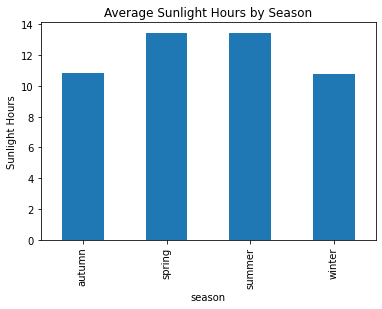

In [39]:
# Plotting average sunlight hours per Season:
df.groupby('season')['Sun Hours'].mean().plot(kind='bar')
plt.xlabel('season')
plt.ylabel('Sunlight Hours')
plt.title('Average Sunlight Hours by Season');

I will add the average sunrise and sunset hour to the Average Hourly Energy Consumption Summer and Winter plots: 

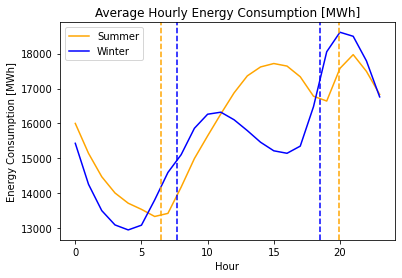

In [40]:
# Define average sunrise and sunset for each 
summer_sunrise = (df[df['season'] == 'summer']['Sunrise'].dt.hour + (df[df['season'] == 'summer']['Sunrise'].dt.minute)/60).mean()
summer_nightfall = (df[df['season'] == 'summer']['Sunset'].dt.hour + (df[df['season'] == 'summer']['Sunset'].dt.minute)/60).mean()
winter_sunrise = (df[df['season'] == 'winter']['Sunrise'].dt.hour + (df[df['season'] == 'winter']['Sunrise'].dt.minute)/60).mean()
winter_nightfall = (df[df['season'] == 'winter']['Sunset'].dt.hour + (df[df['season'] == 'winter']['Sunset'].dt.minute)/60).mean()
df[df['season'] == 'summer'].groupby('Hour')['Consumption [MWh]'].mean().plot(kind='line', label='Summer', color='orange')
df[df['season'] == 'winter'].groupby('Hour')['Consumption [MWh]'].mean().plot(kind='line', label='Winter', color='blue')
plt.axvline(summer_sunrise, linestyle='--', color='orange')
plt.axvline(summer_nightfall, linestyle='--', color='orange')
plt.axvline(winter_sunrise, linestyle='--', color='blue')
plt.axvline(winter_nightfall, linestyle='--', color='blue')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Hourly Energy Consumption [MWh]')
plt.legend();

Longer summer days delay the consumption of energy. Shorter winter days make people start earlier in the morning and the afternoon to use electricity.

But Sun not only impacts in the natural light but also in Temperature, so next step will be to add to the dataset information about temperature and precipitations. 

**Third Step:**

I will now import from Meteostat´s API (https://dev.meteostat.net/python/hourly.html#example) climate information such as Temperature and Precipitations.

After doing that I'll add that information to the dataset.

In [41]:
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(lat, lon)
station = stations.fetch(1)

# Print DataFrame
print(station)

                    name country region    wmo  icao  latitude  longitude  \
id                                                                          
87480  Rosario Aerodrome      AR      S  87480  SAAR  -32.9167   -60.7833   

       elevation                        timezone hourly_start hourly_end  \
id                                                                         
87480       25.0  America/Argentina/Buenos_Aires   1939-02-01 2022-05-29   

      daily_start  daily_end monthly_start monthly_end      distance  
id                                                                    
87480  1965-03-08 2022-05-21    1950-01-01  2021-01-01  58937.917873  


In [42]:
# Set time period
start = datetime(2018, 1, 1)
end = datetime(2022, 12, 31, 23, 59)

# Get hourly data
data = Hourly(station, start, end)
data = data.fetch()

# Print DataFrame
print(data.head(5))
print('')
print(data.index.max())

                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2018-01-01 00:00:00  20.7  19.2  91.0   NaN   NaN  160.0  13.0   NaN  1010.4   
2018-01-01 01:00:00  21.0  18.9  88.0   NaN   NaN  140.0  16.6   NaN  1011.0   
2018-01-01 02:00:00  21.0  16.0  73.0   NaN   NaN  110.0  22.3   NaN  1011.0   
2018-01-01 03:00:00  20.2  16.2  78.0   NaN   NaN  110.0  20.5   NaN  1011.5   
2018-01-01 04:00:00  20.0  16.0  78.0   NaN   NaN  140.0   9.4   NaN  1011.0   

                     tsun  coco  
time                             
2018-01-01 00:00:00   NaN   NaN  
2018-01-01 01:00:00   NaN   NaN  
2018-01-01 02:00:00   NaN   NaN  
2018-01-01 03:00:00   NaN   NaN  
2018-01-01 04:00:00   NaN   NaN  

2021-12-31 23:00:00


There seems to be a limit of 3 years so I will fetch for remaining information:

In [43]:
# Set time period
start = datetime(2022, 1, 1)
end = datetime(2022, 3, 31, 23, 59)

# Get hourly data
data_2 = Hourly(station, start, end)
data_2 = data_2.fetch()

# Print DataFrame
print(data_2.head(5))
print('')
print(data_2.index.max())

                     temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt    pres  \
time                                                                          
2022-01-01 00:00:00  31.7  15.2  37.0   NaN   NaN  70.0   9.4   NaN  1001.1   
2022-01-01 01:00:00  29.8  14.4  39.0   NaN   NaN  70.0  11.2   NaN  1001.2   
2022-01-01 02:00:00  28.7  14.9  43.0   NaN   NaN  90.0   9.4   NaN  1001.2   
2022-01-01 03:00:00  27.5  14.5  45.0   NaN   NaN  90.0   7.6   NaN  1001.6   
2022-01-01 04:00:00  26.6  14.4  47.0   NaN   NaN  90.0   3.6  18.5  1001.4   

                     tsun  coco  
time                             
2022-01-01 00:00:00   NaN   2.0  
2022-01-01 01:00:00   NaN   2.0  
2022-01-01 02:00:00   NaN   2.0  
2022-01-01 03:00:00   NaN   2.0  
2022-01-01 04:00:00   NaN   2.0  

2022-03-31 23:00:00


In [44]:
# Concatenate both dataframes and check shape:
climate = pd.concat([data, data_2])
print(climate.index.max())
print('')
print(climate.shape)

2022-03-31 23:00:00

(45971, 11)


It should had 37.944 rows at most. I will remove duplicates and recheck shape:

In [45]:
climate.drop_duplicates(keep='first', inplace=True)
climate.shape

(37119, 11)

In [46]:
# Drop columns we won´t use
climate.reset_index(drop=False, inplace=True)
climate.rename(columns={'time': 'datetime'}, inplace=True)
# climate['Hour'] = climate['Date'].dt.hour
# climate['Date'] = [datetime.date() for datetime in climate['Date']]
# climate['Date'] = pd.to_datetime(climate['Date'])
climate.drop(columns=['dwpt', 'rhum', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco'], inplace=True)
climate.head()


datetime  temp  prcp
0 2018-01-01 00:00:00  20.7   NaN
1 2018-01-01 01:00:00  21.0   NaN
2 2018-01-01 02:00:00  21.0   NaN
3 2018-01-01 03:00:00  20.2   NaN
4 2018-01-01 04:00:00  20.0   NaN

In [47]:
# Checkin null values:
print(climate.isna().sum())
print(climate.isna().sum()/climate.shape[0])

datetime        0
temp            3
prcp        15785
dtype: int64
datetime    0.000000
temp        0.000081
prcp        0.425254
dtype: float64


There are just 3 missing values for temperature. In the case of precipitations there are almost 5,000, 13%. Let´s plot prcp time series: 

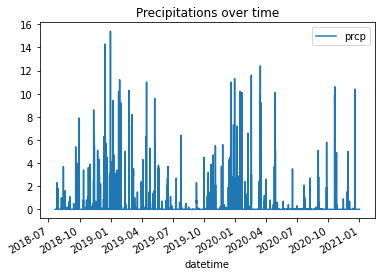

In [48]:
climate.plot(x='datetime', y='prcp')
plt.title('Precipitations over time');

Almost every missing value corresponds to the first half of 2018. Filling NaNs with average values means that at every hour of 2018's first semester was raining while filling them with 0 means that at no hour rained. I think both situations are not reliable so I will prefer to drop this feature.

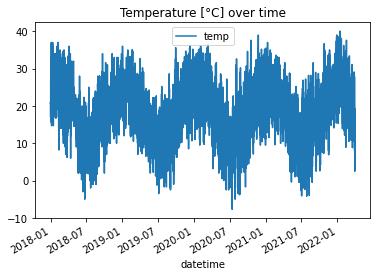

In [49]:
climate.drop(columns=['prcp'], inplace=True)
climate.plot(x='datetime', y='temp')
plt.title('Temperature [°C] over time');

In [50]:
# Adding temperature information to the dataframe:
df = df.merge(climate, how='left', on='datetime')
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]  season  \
0  2018      1    1   Sunday 2018-01-01     0          13115.471  summer   
1  2018      1    1   Sunday 2018-01-01     1          12748.214  summer   
2  2018      1    1   Sunday 2018-01-01     2          12450.384  summer   
3  2018      1    1   Sunday 2018-01-01     3          12114.221  summer   
4  2018      1    1   Sunday 2018-01-01     4          11846.796  summer   

             datetime             Sunrise              Sunset  Sun Hours  sun  \
0 2018-01-01 00:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
1 2018-01-01 01:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
2 2018-01-01 02:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
3 2018-01-01 03:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
4 2018-01-01 04:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   

   temp  
0  20.7  
1  21.0  
2  21.0  
3  20.2  
4  20.0

In [51]:
# Checking for missing values:
df.isnull().sum()

Year                   0
Month                  0
Day                    0
Day Type               0
Date                   0
Hour                   0
Consumption [MWh]      0
season                 0
datetime               0
Sunrise                0
Sunset                 0
Sun Hours              0
sun                    0
temp                 828
dtype: int64

In [52]:
# Filling missing values with linear interpolation:
df.interpolate(axis=0, inplace=True)

In [53]:
# Re-checking for missing values:
df.isnull().sum()

Year                 0
Month                0
Day                  0
Day Type             0
Date                 0
Hour                 0
Consumption [MWh]    0
season               0
datetime             0
Sunrise              0
Sunset               0
Sun Hours            0
sun                  0
temp                 0
dtype: int64

**Fourth Step:**

I will now import information about economic activity level (EMAE) from INDEC and industrial activity level (IPI) from "Fundación Fiel":

In [155]:
economics = pd.read_excel('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/Economics 2018-2022.xlsx')
economics.head()

Year  Month   EMAE         IPI
0  2018      1  142.7  135.429394
1  2018      2  138.8  137.164394
2  2018      3  155.9  162.107533
3  2018      4  151.5  154.507462
4  2018      5  159.6  158.157595

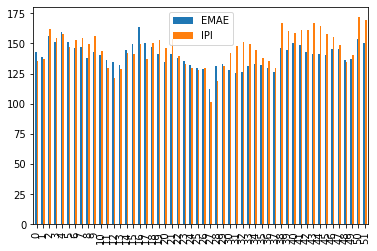

In [156]:
# Plotting both indicators:
economics[['EMAE', 'IPI']].plot(kind='bar');

In [157]:
# Adding information to the dataset:
df = df.merge(economics, how='left', on=['Year', 'Month'])
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]  season  \
0  2018      1    1   Sunday 2018-01-01     0          13115.471  summer   
1  2018      1    1   Sunday 2018-01-01     1          12748.214  summer   
2  2018      1    1   Sunday 2018-01-01     2          12450.384  summer   
3  2018      1    1   Sunday 2018-01-01     3          12114.221  summer   
4  2018      1    1   Sunday 2018-01-01     4          11846.796  summer   

             datetime             Sunrise              Sunset  Sun Hours  sun  \
0 2018-01-01 00:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
1 2018-01-01 01:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
2 2018-01-01 02:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
3 2018-01-01 03:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
4 2018-01-01 04:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   

   temp  EMAE_x       IPI_x  EMAE_y       IPI_y  
0  20.7   142.7  135.429394   142.7  135.429394  
1  21.0   142.7  135.429394   142.7  135.429394  
2  21.0   142.7  135.429394   142.7  135.429394  
3  20.2   142.7  135.429394   142.7  135.429394  
4  20.0   142.7  135.429394   142.7  135.429394

**Fifth Step:**

With this new features I will perfom a new EDA to find insights.

To begin with, I will start with a headmap of correlations:

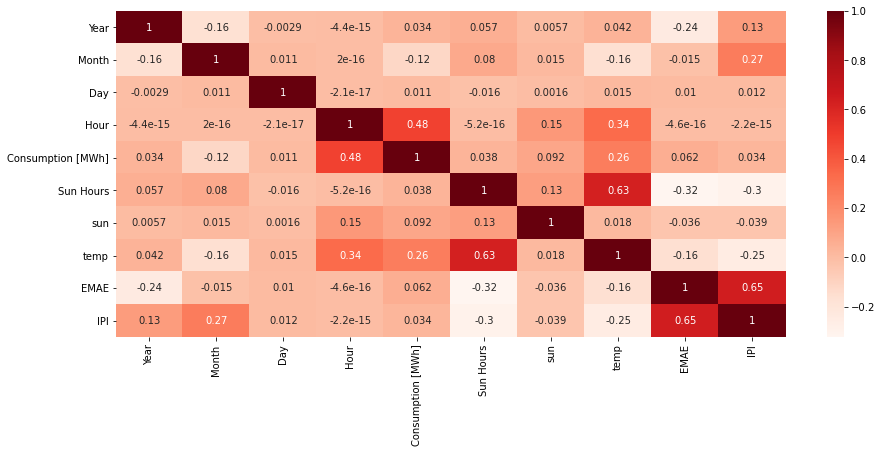

In [57]:
# Create a figure:
fig, ax = plt.subplots(figsize=(15, 6))
# Create matrix of correlations:
corr = df.corr()
# Plot correlations matrix into a heatmap:
sns.heatmap(corr, annot=True, cmap='Reds');

Consumption target feature has an hourly frequency. The other features that respond to hourly frequency are Hour, Sun and temperature. Sun hours has daily frequency and it´s related to daily consumption, while EMAE and IPI are monthly indicators. I will perform visualizations and correlation taking into account this frequencies.

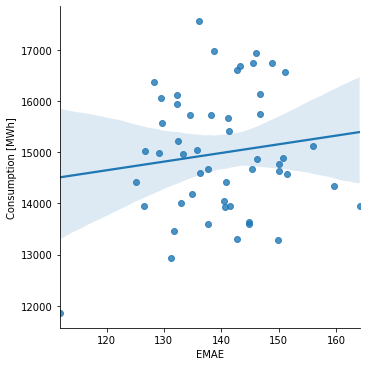

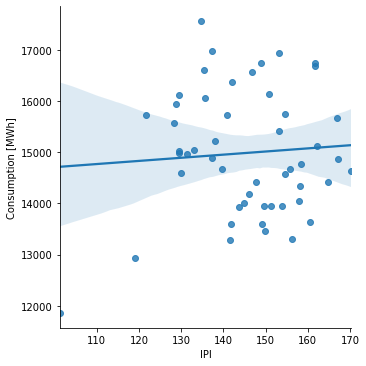

In [58]:
# Grouping information by Year and Month:
energy_vs_economics = df.groupby(['Year', 'Month'])[['Consumption [MWh]', 'EMAE', 'IPI']].mean()
# Plotting each economic indicator vs monthly average consumption:
sns.lmplot(data=energy_vs_economics, x='EMAE', y='Consumption [MWh]')
sns.lmplot(data=energy_vs_economics, x='IPI', y='Consumption [MWh]');

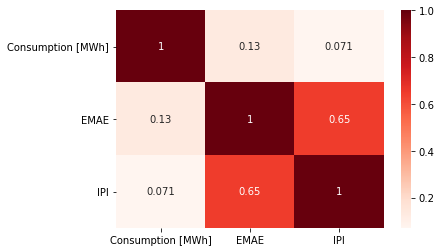

In [59]:
# Plot correlations matrix into a heatmap:
sns.heatmap(energy_vs_economics.corr(), annot=True, cmap='Reds');

Both graphs look alike with almost no linear correlation. Key takeaway is that EMAE and IPI are strongly correlated to each other so I will choose for the model only one of those features, the one that performs better.

I will continue with daily frequency with daily consumption, sun hours and day type, but also adding the monthly average temperature:

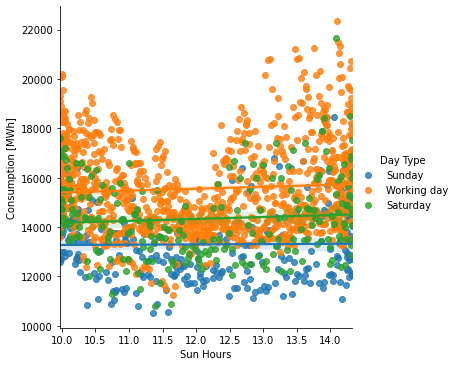

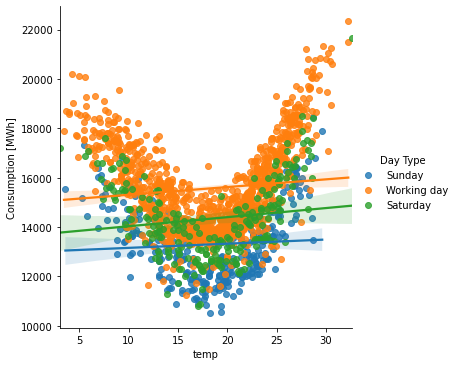

In [60]:
# Grouping consumption by year:
energy_vs_sunhours = df.groupby(['Year', 'Month', 'Day'])[['Consumption [MWh]', 'Sun Hours', 'temp']].mean()
# Merging with df to colour by Day Type:
energy_vs_sunhours = energy_vs_sunhours.merge(df[['Year', 'Month', 'Day', 'Day Type']].
                                              drop_duplicates(keep='first'), how='left', on=['Year', 'Month', 'Day'])
sns.lmplot(data=energy_vs_sunhours, x='Sun Hours', y='Consumption [MWh]', hue='Day Type');
sns.lmplot(data=energy_vs_sunhours, x='temp', y='Consumption [MWh]', hue='Day Type');

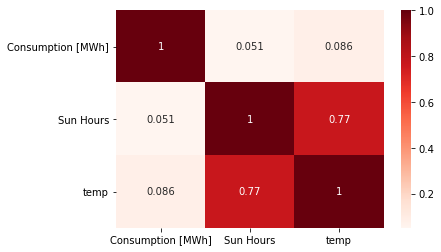

In [61]:
# Plot correlations matrix into a heatmap:
sns.heatmap(energy_vs_sunhours[['Consumption [MWh]', 'Sun Hours', 'temp']].corr(), annot=True, cmap='Reds');

Day Type has a big influence in energy consumption. Low and high Sun Hours (Winter and Summer) as well as low and high temperatures explain peaks in energy consumption. Monthly Sun hours and Temperature are highly correlated. There's no need to keep one of the them as in the dataset they have different frequencies.

I will continue now with hourly frequencies features: boolean Sun's presence, temperature and hourly energy consumption:

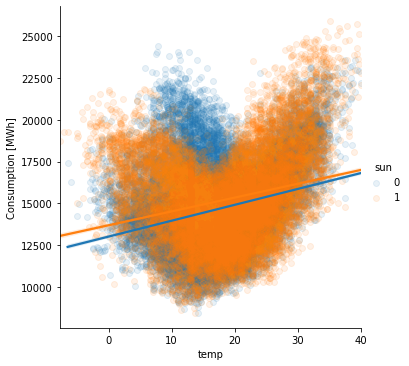

In [62]:
# Plotting Consumtion vs Temperature, color by sun's presence:
sns.lmplot(data=df, x='temp', y='Consumption [MWh]', hue='sun', scatter_kws={'alpha':0.1});

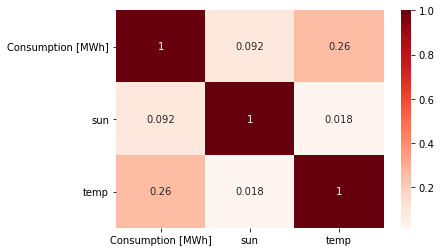

In [63]:
# Plot correlations matrix into a heatmap:
sns.heatmap(df[['Consumption [MWh]', 'sun', 'temp']].corr(), annot=True, cmap='Reds');

This plot just confirms the impact of temperature (low and high) in energy consumption. The curve's shape looks more like a parabolic, explaining the low linear correlation rate.

## 3) Model Selection

In this part of the project I will develop regression models to predict energy consumption base in the new features added to the dataset (temperature, sun hours, sun's presence, economics). The only features that will remain from the original dataset will be the hour, season and day type.

As we could see in previous section, there are no strong linear correlations between features and target variable (energy consumption), so I will train and test tree based models.

**Input Preparation:**

I will begin splitting the dataset into two datasets. The first dataset (3 years and 4 months) will be used to fit and test the different models. The second dataset (1 year) will be used to predict energy consumption in different time zones. Then, the first dataset will be split again into train and test df.

In [64]:
# Printing df columns
df.columns

Index(['Year', 'Month', 'Day', 'Day Type', 'Date', 'Hour', 'Consumption [MWh]',
       'season', 'datetime', 'Sunrise', 'Sunset', 'Sun Hours', 'sun', 'temp',
       'EMAE', 'IPI'],
      dtype='object')

In [454]:
# Choosing features to be used in the model selection:
features = ['Day Type', 'Hour', 'Consumption [MWh]', 'Sun Hours', 'temp', 'IPI', 'season', 'EMAE', 'sun']
target = ['Consumption [MWh]']
# Defining cutoff date to split dataframe in two:
cutoff = '2022-01-01'
# Df splitting and slicing:
df_model = df[df['Date'] < cutoff][features]
# Printing shapes and % of split:
print(df_model.shape, round(df_model.shape[0]/df.shape[0],2))

(35064, 9) 0.92


In [405]:
# Slicing features from target variable:
X = df_model.drop(target, axis=1)
y = df_model[target]
# Splitting into train and test datasets and printing shapes:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(28032, 8) (28032, 1)
(7008, 8) (7008, 1)


**First Model**: *Decision Tree Regressor*

Now, I will start to develop the first model: a Decision Tree Regressor. To do so I will start by building a pipeline with an Ordinal Encoder to transform categorical features (Day Type and Season) into numerical features, and a Decision Tree Regressor with default hyperparameters:

In [406]:
# Make a pipeline with a first step of encoding categorical features (Season and Day Type) + initializating a 
# Decison Tree Regressor:
ord_enc = OrdinalEncoder()
dt = DecisionTreeRegressor(random_state=1)
pipe = make_pipeline(ord_enc, dt)
pipe.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Day Type', 'season'],
                                mapping=[{'col': 'Day Type',
                                          'data_type': dtype('O'),
                                          'mapping': Sunday         1
Working day    2
Saturday       3
NaN           -2
dtype: int64},
                                         {'col': 'season',
                                          'data_type': dtype('O'),
                                          'mapping': autumn    1
spring    2
summer    3
winter    4
NaN      -2
dtype: int64}])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=1))])

I will plot feature importance to better understand how model to decides:

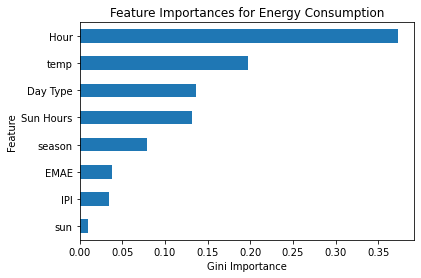

In [407]:
# Get importances and feature_names:
importance = pipe[1].feature_importances_
features = pipe[0].get_feature_names()
feat_imp = pd.Series(importance, index=features).sort_values(key=abs)
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Energy Consumption');

We can see that boolean feature of Sun's presence has no importance at all. And as we thought in EDA section we just can keep one of the economics features (IPI and EMAE). I will choose IPI as it is more important.

In [455]:
drop_features = ['sun', 'EMAE']
X_train.drop(drop_features, axis=1, inplace=True)
X_test.drop(drop_features, axis=1, inplace=True)

KeyError: "['sun' 'EMAE'] not found in axis"

In [456]:
# Update features to be considered in features list:
features = [f for f in features if f not in drop_features]
features

['Day Type', 'Hour', 'Consumption [MWh]', 'Sun Hours', 'temp', 'IPI', 'season']

In [410]:
# Fit pipeline with selected features:
pipe.fit(X_train, y_train)
# Predict Energy Consumption for train and test datasets and compute RSME:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)
dt_train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
dt_test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
print("Decision Tree Train RMSE:", dt_train_rmse.round(2))
print("Decision Tree Test RMSE:", dt_test_rmse.round(2))

Decision Tree Train RMSE: 0.0
Decision Tree Test RMSE: 873.68


We can see that this model has no error for train data, but it do has error for test data. That means that de model is overfitting, it learned train data but can´t replicate that performance with unseen data. To fix this hyperparameter tunning must be done. First let´s see what parameters this model has:

In [411]:
pipe[1].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [412]:
pipe[1].get_depth()

34

Most common hyperparameters to be tunned in a Decision Tree are max_depth and min_samples_leaf. The first model fit to a max_depth of 39 and had min_samples_leaf default of 1.

Now I will perform a Grid Search Cross Validation to find optimal value for max depth and min_samples_leaf:

In [413]:
# Grid definition:
max_depths = np.arange(5, 51, 5)
min_samples_leaf = np.arange(2, 11, 2)
param_grid = {'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf}
# Initialization of GridSearchCV and adding to pipeline:
gs = GridSearchCV(estimator=dt, param_grid=param_grid, cv=4, scoring='neg_mean_squared_error', verbose=0, refit=True)
pipe_gs = make_pipeline(ord_enc, gs)
# Fitting pipeline with train data:
pipe_gs.fit(X_train, y_train)
# Predict Energy Consumption for train and test datasets and compute RSME:
y_pred_train = pipe_gs.predict(X_train)
y_pred_test = pipe_gs.predict(X_test)
gs_dt_train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
gs_dt_test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
print("Decision Tree Train RMSE:", gs_dt_train_rmse.round(2))
print("Decision Tree Test RMSE:", gs_dt_test_rmse.round(2))
# Printing optimal parameters:
print(gs.best_params_)

Decision Tree Train RMSE: 500.03
Decision Tree Test RMSE: 818.78
{'max_depth': 20, 'min_samples_leaf': 4}


Optimal value for max_depth was 25 and for min_samples_leaf was 4. This lead model to a better performance, with a RMSE of around 780 vs 845 of the model without being tunned.

Let's see how performance varied with the hyperparameters:

In [414]:
#  Getting results into a Dataframe and priting column names:
gs_results = pd.DataFrame(gs.cv_results_)
gs_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [415]:
# Choosing columns of interest and calculating RMSE:
cols = ['params','param_max_depth','param_min_samples_leaf','mean_test_score']
gs_results = gs_results[cols]
gs_results['mean_test_rmse'] = (gs_results['mean_test_score'] * -1) ** 0.5

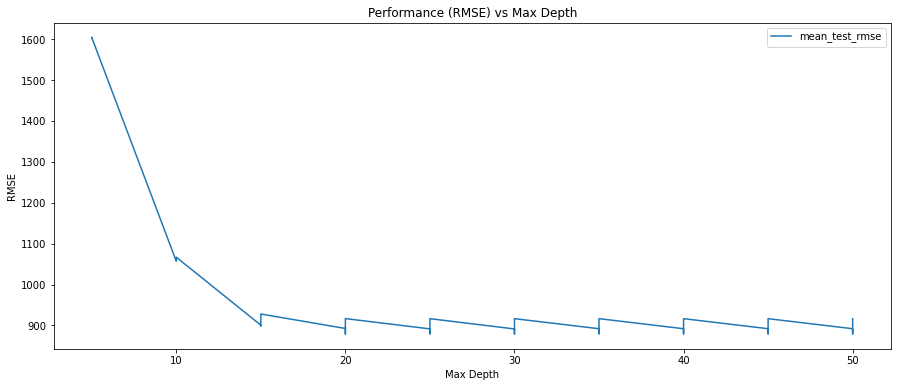

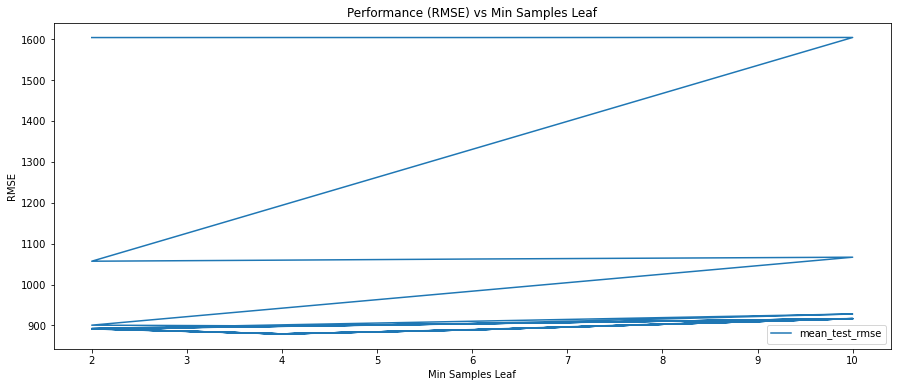

In [416]:
# Plotting RMSE vs Max Depth and Min Samples Leaf:
fig, ax = plt.subplots(figsize=(15, 6))
gs_results.plot(ax=ax, x='param_max_depth', y='mean_test_rmse')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Performance (RMSE) vs Max Depth');
fig, ax = plt.subplots(figsize=(15, 6))
gs_results.plot(ax=ax, x='param_min_samples_leaf', y='mean_test_rmse')
plt.xlabel('Min Samples Leaf')
plt.ylabel('RMSE')
plt.title('Performance (RMSE) vs Min Samples Leaf');

Though visualizations are not really clear, what we can conclude is that from a max_depth = 20 onwards performance tends to stabilize. Regarding min_samples_leaf, it has a minimum RMSE in 4.

To make it clearer, I will plot performance vs max_depth for different min_samples_leaf values:

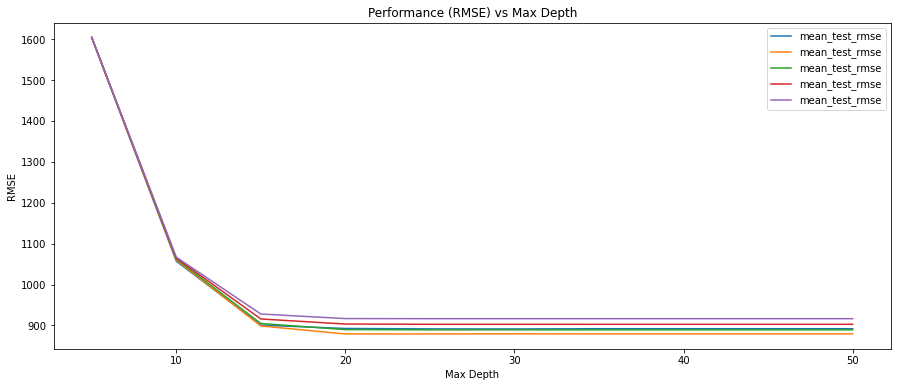

In [417]:
fig, ax = plt.subplots(figsize=(15, 6))
for msl in min_samples_leaf.tolist():
    gs_results[gs_results['param_min_samples_leaf'] == msl].plot(ax=ax, x='param_max_depth', y='mean_test_rmse')
    plt.xlabel('Max Depth')
    plt.ylabel('RMSE')
    plt.title('Performance (RMSE) vs Max Depth');

Decision Tree Regressor was fitted and hypertunned, ending with a RMSE of around 780. Let's include it´s performance to performance dictionary and move on into a new model:

In [418]:
# Add RMSE to the performance dictionary:
model_performance['3 - Decision Tree'] = gs_dt_test_rmse.round(2)
print(model_performance)

{'0 - Mean': 2681.08, '1 - AR': 2660.49, '2 - AR_wfv': 171.53, '3 - Decision Tree': 818.78, '4 - Random Forest': 588.26, '5 - XGB': 315.44}


**Second Model**: *Random Forest Regressor*

Now, I will start to develop the second model: a Random Forest Regressor. I will proceed like I have done with the Decision Tree, following the same procedure.

This algorithm is more time consuming than a decision tree, so I will asign more cpu (n_jobs) as well as measuring how much time takes to run.

In [419]:
# Printing number of cores in computer:
print(os.cpu_count())

8


In [420]:
# Make a pipeline with a first step of encoding categorical features (Season and Type of Day) + 
# initializating a Random Forest Regressor:
oe = OrdinalEncoder()
rf = RandomForestRegressor(random_state=1, n_jobs=6)
pipe_rf = make_pipeline(oe, rf)
pipe_rf.fit(X_train, y_train.values.ravel())
# Predict Energy Consumption for train and test datasets and compute de RSME:
y_pred_train = pipe_rf.predict(X_train)
y_pred_test = pipe_rf.predict(X_test)
rf_train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
rf_test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
print("Random Forest Train RMSE:", rf_train_rmse.round(2))
print("Random Forest Test RMSE:", rf_test_rmse.round(2))

Random Forest Train RMSE: 230.41
Random Forest Test RMSE: 604.33


In [421]:
pipe_rf[1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 6,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Random Forest with 100 estimators had a RMSE of almost 595. I will proceed to perform a Randomized Search CV defining the number of interations. I choose Randomized Search vs GridSearch because Random Forest with higher number of estimators is really time consuming. This will give us an idea of where to tune hyperparameters:

In [422]:
# Grid definition:
n_estimators = [10, 50, 100, 200, 500, 1000]
max_depths = np.arange(10, 101, 10)
min_samples_leaf = np.arange(1, 11, 1)
max_features = ['auto', 'log2', None]
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features}
# Initialization of GridSearchCV and adding to pipeline:
rs_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=3, n_jobs=6, n_iter=20,
                           scoring='neg_mean_squared_error', verbose=0, refit=True)
pipe_rs_rf = make_pipeline(oe, rs_rf)
# Fitting pipeline with train data:
pipe_rs_rf.fit(X_train, y_train.values.ravel())
# Predict Energy Consumption for train and test datasets and compute RSME:
y_pred_train = pipe_rs_rf.predict(X_train)
y_pred_test = pipe_rs_rf.predict(X_test)
rs_rf_train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
rs_rf_test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
print("Random Forest Train RMSE:", rs_rf_train_rmse.round(2))
print("Random Forest Test RMSE:", rs_rf_test_rmse.round(2))
# Printing optimal parameters:
print(rs_rf.best_params_)

Random Forest Train RMSE: 381.33
Random Forest Test RMSE: 602.96
{'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}


There was no much improvement with a more expensive model, so I will stick to the first model created (pipe_rf):

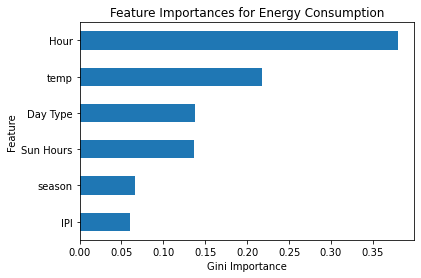

In [423]:
# Get importances and feature_names:
importance = pipe_rf[1].feature_importances_
features = pipe_rf[0].get_feature_names()
feat_imp = pd.Series(importance, index=features).sort_values(key=abs)
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Energy Consumption');

Feature's importances look similar to the decision tree model. The only change is between IPI and season. Let´s add performance to the dictionary and move onto the last model to develop, a XGBoost Regressor: 

In [424]:
# Add RMSE to the performance dictionary:
model_performance['4 - Random Forest'] = rf_test_rmse.round(2)
print(model_performance)

{'0 - Mean': 2681.08, '1 - AR': 2660.49, '2 - AR_wfv': 171.53, '3 - Decision Tree': 818.78, '4 - Random Forest': 604.33, '5 - XGB': 315.44}


**Third Model**: *XGBoost Regressor*

Now, I will start to develop the third model: a XGBoost Regressor. I will proceed like I have done with previous models:

In [425]:
xgb = XGBRegressor(seed=1, n_jobs=6, booster='gbtree', verbosity=0, eval_metric='rmse')
pipe_xgb = make_pipeline(oe, xgb)
pipe_xgb.fit(X_train, y_train)
xgb_y_pred_train = pipe_xgb.predict(X_train)
xgb_y_pred_test = pipe_xgb.predict(X_test)
xgb_train_rmse = mean_squared_error(y_train, xgb_y_pred_train) ** 0.5
xgb_test_rmse = mean_squared_error(y_test, xgb_y_pred_test) ** 0.5
print("XGB Train RMSE:", xgb_train_rmse.round(2))
print("XGB Test RMSE:", xgb_test_rmse.round(2))

XGB Train RMSE: 448.29
XGB Test RMSE: 535.83


First result for the XGB performed better than previous models. Let´s tune model to see if this performance can get better:

In [426]:
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 6,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'seed': 1}

In [427]:
# Grid definition:
n_estimators = [50, 100, 500, 1000]
max_depths = np.arange(10, 51, 10)
learning_rate = [0.01, 0.1, 0.5]
subsample = [0.3, 0.5]
alpha = [0., 0.5, 1]
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depths,
              'learning_rate': learning_rate,
              'subsample': subsample,
              'alpha': alpha}
# Initialization of GridSearchCV and adding to pipeline:
rs_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=3, n_jobs=6, n_iter=30,
                           scoring='neg_mean_squared_error', verbose=0, refit=True)
pipe_rs_xgb = make_pipeline(oe, rs_xgb)
# Fitting pipeline with train data:
pipe_rs_xgb.fit(X_train, y_train)
# Predict Energy Consumption for train and test datasets and compute RSME:
y_pred_train = pipe_rs_xgb.predict(X_train)
y_pred_test = pipe_rs_xgb.predict(X_test)
rs_xgb_train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
rs_xgb_test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
print("XGB Train RMSE:", rs_xgb_train_rmse.round(2))
print("XGB Test RMSE:", rs_xgb_test_rmse.round(2))
# Printing optimal parameters:
print(rs_xgb.best_params_)

C:\Users\Mariano\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



XGB Train RMSE: 54.97
XGB Test RMSE: 325.84
{'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'alpha': 0.0}


Excellent performance! Models went from a Decision Tree with RMSE of 850 to a XGBoost regressor with a RMSE of 320. Really great improvement, and with a "similar" performance to the AR WFV model develop over timeseries dataset!

To end with model selection part of the project I will plot feature importances for XGB regressor, save the best model and add performance to dictionary:

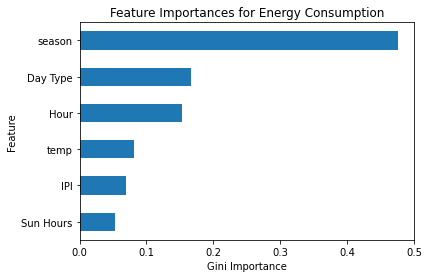

In [428]:
# Get importances and feature_names:
importance = rs_xgb.best_estimator_.feature_importances_
features = pipe_xgb[0].get_feature_names()
feat_imp = pd.Series(importance, index=features).sort_values(key=abs)
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Energy Consumption');

XGBoost Regressor change significantly feature importances vs Decision Tree or Random Forest Regressors.

{'0 - Mean': 2681.08, '1 - AR': 2660.49, '2 - AR_wfv': 171.53, '3 - Decision Tree': 818.78, '4 - Random Forest': 604.33, '5 - XGB': 325.84}


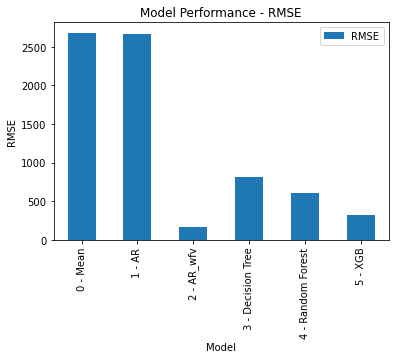

In [429]:
xgb_best = rs_xgb.best_estimator_
pipe_best = make_pipeline(oe, xgb_best)
# Add RMSE to the performance dictionary:
model_performance['5 - XGB'] = rs_xgb_test_rmse.round(2)
print(model_performance)
pd.DataFrame.from_dict(model_performance, orient = 'index', columns=['RMSE']).plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Performance - RMSE');

## 4) Energy Consumption Predictions 

Finally we reach the last part of the project, where I will use the XGB model to predict energy consumption for actual time zone and for different scenarios, like:

    -> sc1: UTC -3: Actual time zone
    -> sc2: UTC -3 / UTC -2: Actual time zone + summer time
    -> sc3: UTC -4: New time zone
    -> sc4: UTC -4 / UTC -3: Nex time zone + summer time

### A. Data Preparation:

**First Step:**

To begin with I will add to the selected features the 'Date' as it will be used to change time zone during scenarios with summer time. Then I will create one dataframe for each of the mentioned scenarios, dropping 'Date' so this dataframes can feed the model:

In [457]:
# Adding data to features:
features.append('Date')
features

['Day Type',
 'Hour',
 'Consumption [MWh]',
 'Sun Hours',
 'temp',
 'IPI',
 'season',
 'Date']

In [472]:
# Df for predictions slicing:
df_predict = df[df['Date'] >= cutoff][features]
y = df_predict['Consumption [MWh]']
# Printing shape and % of split:
print(df_predict.shape, round(df_predict.shape[0]/df.shape[0],2))
print(df_predict.head(5))

(2880, 8) 0.08
      Day Type  Hour  Consumption [MWh]  Sun Hours  temp         IPI  season  \
35064   Sunday     0          15892.340  14.279167  31.7  134.607687  summer   
35065   Sunday     1          15965.211  14.279167  29.8  134.607687  summer   
35066   Sunday     2          16244.469  14.279167  28.7  134.607687  summer   
35067   Sunday     3          16314.117  14.279167  27.5  134.607687  summer   
35068   Sunday     4          16104.439  14.279167  26.6  134.607687  summer   

            Date  
35064 2022-01-01  
35065 2022-01-01  
35066 2022-01-01  
35067 2022-01-01  
35068 2022-01-01  


In [473]:
y.shape

(2880,)

In [462]:
def change_hour(df, start, end, hour):
    new_df = df.copy()
    dates = pd.date_range(start, end)
    new_hour = []
    for i in new_df.index:
        if new_df['Date'][i] in dates:
            new_hour.append(new_df['Hour'][i] + hour)
        else:
            new_hour.append(new_df['Hour'][i])
    new_hour = [h + 24 if h < 0 else h - 24 if h > 23 else h for h in new_hour]
    new_df['Hour'] = new_hour
    return new_df

In [474]:
def make_prediction(df):
    X = df.drop(columns=['Date', 'Consumption [MWh]'])
    pred = pipe_best.predict(X)
    return pred

In [475]:
sc1 = make_prediction(change_hour(df_predict, start = '2022-01-01', end = '2022-04-30', hour=0))
sc1_rmse = mean_squared_error(y, sc1) ** 0.5
print("Scenario 1 RMSE:", sc1_rmse.round(2))

Scenario 1 RMSE: 1288.23


In [476]:
sc2 = make_prediction(change_hour(df_predict, start = '2022-01-01', end = '2022-04-30', hour=+1))

In [477]:
sc3 = make_prediction(change_hour(df_predict, start = '2022-01-01', end = '2022-04-30', hour=-1))

In [478]:
sc4 = make_prediction(change_hour(df_predict, start = '2022-01-01', end = '2022-04-30', hour=+12))

In [479]:
avg_cons_new_utc = pd.Series(y_sc3).mean()
avg_cons_actual_utc = y.mean()
print("Avg Energy Consumption UTC-4:", np.round(avg_cons_new_utc, 2))
print("Avg Energy Consumption UTC-3:", np.round(avg_cons_actual_utc, 2))

Avg Energy Consumption UTC-4: 14809.28
Avg Energy Consumption UTC-3: 15510.05


In [480]:
scenarios_dict = {'Date': df_predict['Date'],
                  'Hour': df_predict['Hour'],
                  'Actual UTC-3': df_predict['Consumption [MWh]'],
                  'Prediction UTC-3': sc1,
                  'Prediction UTC-2': sc2,
                  'Prediction UTC-4': sc3,
                  'Prediction UTC-15': sc4}
scenarios = pd.DataFrame(scenarios_dict)

In [481]:
scenarios.head()

Date  Hour  Actual UTC-3  Prediction UTC-3  Prediction UTC-2  \
35064 2022-01-01     0     15892.340      17729.458984      17045.531250   
35065 2022-01-01     1     15965.211      16364.723633      15231.385742   
35066 2022-01-01     2     16244.469      15381.762695      14773.680664   
35067 2022-01-01     3     16314.117      14903.126953      14456.166992   
35068 2022-01-01     4     16104.439      13892.290039      13554.625000   

       Prediction UTC-4  Prediction UTC-15  
35064      17627.947266       17098.175781  
35065      17103.291016       15184.669922  
35066      15953.899414       14014.799805  
35067      15216.473633       13229.012695  
35068      14031.787109       12405.673828

In [482]:
scenarios.columns

Index(['Date', 'Hour', 'Actual UTC-3', 'Prediction UTC-3', 'Prediction UTC-2',
       'Prediction UTC-4', 'Prediction UTC-15'],
      dtype='object')

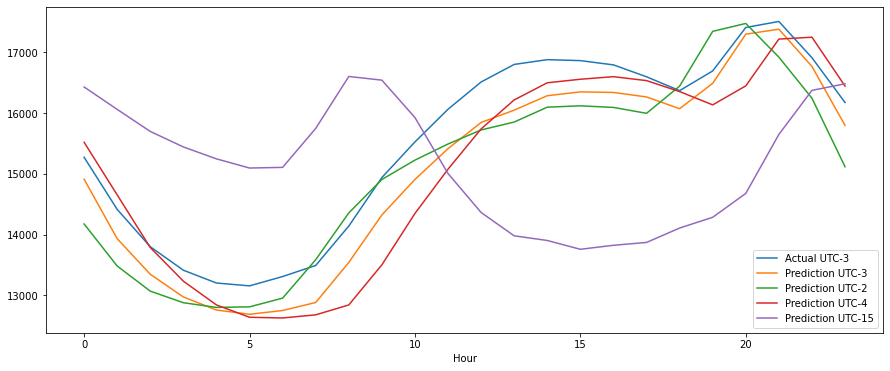

In [484]:
fig, ax = plt.subplots(figsize=(15, 6))
scenarios.groupby('Hour')[['Actual UTC-3', 'Prediction UTC-3', 'Prediction UTC-2',
       'Prediction UTC-4', 'Prediction UTC-15']].mean().plot(ax=ax, kind='line');

<AxesSubplot:>

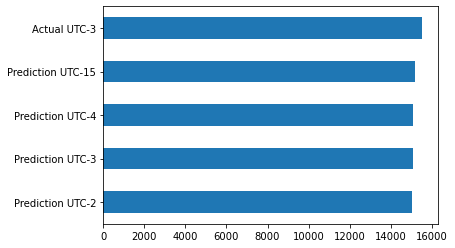

In [487]:
scenarios[['Actual UTC-3', 'Prediction UTC-3', 'Prediction UTC-4',
       'Prediction UTC-2', 'Prediction UTC-15']].mean().sort_values().plot(kind='barh')

In [488]:
scenarios[['Actual UTC-3', 'Prediction UTC-3', 'Prediction UTC-4',
       'Prediction UTC-2', 'Prediction UTC-15']].mean().sort_values()

Prediction UTC-2     15049.016602
Prediction UTC-3     15057.633789
Prediction UTC-4     15073.109375
Prediction UTC-15    15174.398438
Actual UTC-3         15510.050910
dtype: float64

In [489]:
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]  season  \
0  2018      1    1   Sunday 2018-01-01     0          13115.471  summer   
1  2018      1    1   Sunday 2018-01-01     1          12748.214  summer   
2  2018      1    1   Sunday 2018-01-01     2          12450.384  summer   
3  2018      1    1   Sunday 2018-01-01     3          12114.221  summer   
4  2018      1    1   Sunday 2018-01-01     4          11846.796  summer   

             datetime             Sunrise              Sunset  Sun Hours  sun  \
0 2018-01-01 00:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
1 2018-01-01 01:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
2 2018-01-01 02:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
3 2018-01-01 03:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
4 2018-01-01 04:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   

   temp   EMAE         IPI  
0  20.7  142.7  135.429394  
1  21.0  142.7  135.429394  
2  21.0  142.7  135.429394  
3  20.2  142.7  135.429394  
4  20.0  142.7  135.429394

In [496]:
df[df['season'] == 'summer'].groupby('Year')[['Consumption [MWh]', 'temp', 'IPI']].mean()

Consumption [MWh]       temp         IPI
Year                                          
2018       16372.357219  24.670463  141.223735
2019       15245.965299  23.317407  129.716558
2020       15953.636653  24.218819  130.136517
2021       15938.257083  24.066991  142.394626
2022       16232.667631  23.791350  146.295305